In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

In [117]:
def plot_translations(t_gt, t_imu, t_vo_normed, scaler, folder="figures/raw/", filename="translation_gt"):
    xmin, ymin = np.min(t_gt, axis=0)
    xmax, ymax = np.max(t_gt, axis=0)
    
    t_imu_mu = t_imu[0]
    t_imu_cov = t_imu[1]
    
    for i, t_gt_i in enumerate(t_gt):
        fname = folder + filename + "_" + str(i)
        plot_translation(t_gt_i, t_imu_mu[i], t_imu_cov[i, :, :], t_vo_normed[i, :], scaler[ii], filename=fname, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

def plot_translation(t_gt, t_imu_mu, t_imu_cov, t_vo, scaler, filename, xmin, xmax, ymin, ymax):
    ellipse = plot_ellipse(t_imu_mu, t_imu_cov)

    f, ax = plt.subplots()
    ax.add_patch(ellipse)
    gt = ax.arrow(0, 0, t_gt[0], t_gt[1], head_width=0.05, head_length=0.1, fc='k', ec='k', label="gt")
#     vo_n= ax.arrow(0, 0, t_vo[0], t_vo[1], head_width=0.05, head_length=0.1, fc='g', ec='g', label="vo_n")
    vo = ax.arrow(0, 0, t_vo[0]*scaler[0], t_vo[1]*scaler[0], head_width=0.05, head_length=0.1, fc='r', ec='r', label="vo")
    
    ax.scatter(t_imu_mu[0], t_imu_mu[1])
    ellipse.set_clip_box(ax.bbox)
    ax.grid(which="both")
#     ax.minorticks_on()
    ax.legend()
#     ax.axis('equal')
    ax.set_xlim([0, 1.5])
    ax.set_ylim([0, .8])

    f.savefig(fname=filename)
    plt.close(f)
    
def plot_ellipse(t_imu_mu, t_imu_cov):
    nstd = 2
    lambda_, v = eigen(t_imu_cov)
    theta = np.degrees(np.arctan2(*v[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(lambda_)
    
    ell = Ellipse(xy=t_imu_mu,
                  width=w, height=h,
                  angle=theta, edgecolor="blue", label="imu")
    
    ell.set_facecolor('none')
    return ell 

    
def plot_ellipse2(t_imu_mu, t_imu_cov):
    nstd = 2
    lambda_, v = eigen(t_imu_cov)
    theta = np.degrees(np.arctan2(*v[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(lambda_)
    
    ell = Ellipse(xy=t_imu_mu,
                  width=w, height=h,
                  angle=theta, edgecolor="blue", label="_imu")
    
    ell.set_facecolor('none')
    return ell 
        
def eigen(cov):
    lambda_, v = eigsorted(cov)
    lambda_ = np.sqrt(lambda_)
    return lambda_, v

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def mahal_dist(XA, XB):
    from scipy.spatial import distance
    d = distance.mahalanobis(XA, np.mean(XB, axis=0), np.linalg.inv(np.cov(XB.T)))
    return d

def mahal_dist2(XA, mean, icov):
    from scipy.spatial import distance
    d = distance.mahalanobis(XA, mean, icov)
    return d

def cost(lambda_, X):
    XA = X[0]
    XB = X[1]
    return mahal_dist(XA*lambda_, XB)

def cost2(lambda_, X):
    XA = X[0]
    mean = X[1]
    icov = X[2]
    return mahal_dist2(XA*lambda_, mean, icov)

def calculate_scaler(t_vo, t_gt):
    from scipy.optimize import minimize
    bnds = (0, None)
    res = minimize(cost, 1, [t_vo, t_gt])
    return res

def calculate_scaler2(t_vo, mu, sigma):
    from scipy.optimize import minimize
    bnds = (0, None)
    res = minimize(cost2, 1, [t_vo, mu, sigma])
    return res

In [165]:
np.random.seed(9)
car_velocity = np.array([1, 0]) # m/s
f_sampling = 50
n_trials = 20
t_gt_x = np.random.rand(n_trials, 1)+car_velocity[0]/f_sampling
t_gt_y = np.random.rand(n_trials, 1)/5+car_velocity[1]/f_sampling
t_gt = np.hstack([t_gt_x, t_gt_y])

t_imu_mu_x = t_gt_x + np.random.rand(n_trials, 1)*0.5
t_imu_mu_y = t_gt_y + np.random.rand(n_trials, 1)*0.5
t_imu_mu = np.hstack([t_imu_mu_x, t_imu_mu_y])
t_imu_cov = np.zeros((n_trials, 2, 2), dtype=np.float64)

t_vo = t_gt + np.random.rand(n_trials, 2)/50
t_vo_normed = t_vo/np.linalg.norm(t_vo, axis=1).reshape(-1, 1)

scaler = np.zeros((n_trials, 1), dtype=np.float64)

for ii in range(n_trials):
    t_imu_cov[ii, :, :] = np.array([[1,0.4],[0.4,.3]]) * np.float64((ii+1)**2)/10000
    res2 = calculate_scaler2(t_vo_normed[ii, :], t_imu_mu[ii, :].reshape(-1, 1), np.linalg.inv(t_imu_cov[ii, :, :]))
    scaler[ii] = res2.x
    
t_imu = (t_imu_mu, t_imu_cov)

plot_translations(t_gt, t_imu=t_imu, t_vo_normed=t_vo_normed, scaler=scaler)

In [166]:
e_vo = t_gt - (t_vo_normed*scaler)
e_io = t_gt - (t_imu_mu)

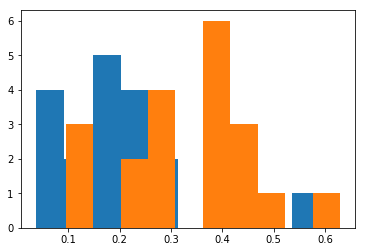

In [167]:
np.mean(np.linalg.norm(e_vo, axis=1)), np.mean(np.linalg.norm(e_io, axis=1))

_ = plt.hist(np.linalg.norm(e_vo, axis=1))
_ = plt.hist(np.linalg.norm(e_io, axis=1))

In [168]:
odom_gt = np.cumsum(t_gt, axis=0)
odom_imu = np.cumsum(t_imu_mu, axis=0)
odom_vo = np.cumsum(t_vo_normed*scaler, axis=0)

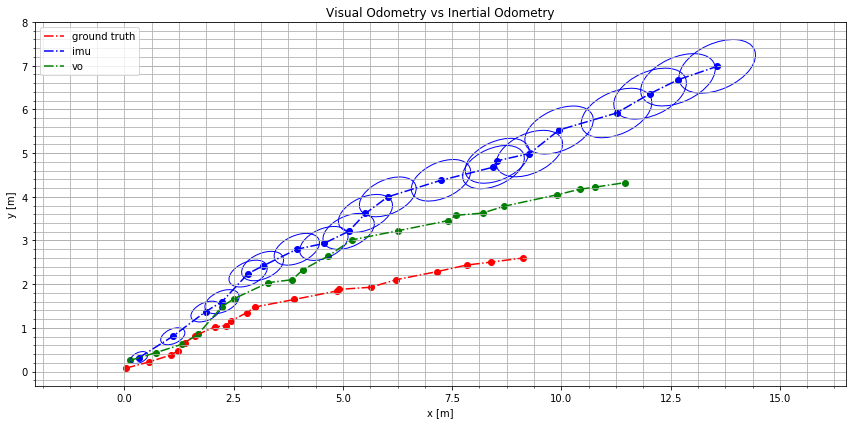

In [169]:
f, ax = plt.subplots(1, 1)
f.set_figheight(6)
f.set_figwidth(12)
ax.plot(odom_gt[:, 0], odom_gt[:, 1], label="ground truth", color="red", linestyle="-.")
ax.scatter(odom_gt[:, 0], odom_gt[:, 1], label="_ground truth", color="red")

ax.plot(odom_imu[:, 0], odom_imu[:, 1], label="imu", color="blue", linestyle="-.")
ax.scatter(odom_imu[:, 0], odom_imu[:, 1], label="_imu", color="blue")

ax.plot(odom_vo[:, 0], odom_vo[:, 1], label="vo", color="green", linestyle="-.")
ax.scatter(odom_vo[:, 0], odom_vo[:, 1], label="_vo", color="green")

for i in range(n_trials):
    ellipse = plot_ellipse2(odom_imu[i, :], t_imu_cov[i, :])
    ax.add_patch(ellipse)
    ellipse.set_clip_box(ax.bbox)
plt.legend()
plt.minorticks_on()


plt.grid(which="both")
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Visual Odometry vs Inertial Odometry")
plt.tight_layout()
plt.savefig(fname="figures/odom")

In [174]:
np.mean(np.linalg.norm(odom_gt - odom_imu, axis=1)), np.linalg.norm(odom_gt - odom_vo, axis=1)

array([0.20466708, 0.28153176, 0.34428717, 0.59297039, 1.18035066,
       1.21580985, 1.5948091 , 1.83750042, 2.03175927, 2.25535105,
       2.69141389, 2.85154249, 3.00982753, 3.1716179 , 3.07406116,
       2.98495779, 3.26746549, 3.11787133, 2.92879566, 2.90277806])